### Imports und GPU Fixes

In [1]:
# Imports
import os
import warnings

# === WARNUNGEN STUMMSCHALTEN ===

# 1. Python-Warnungen
warnings.filterwarnings('ignore')

# 2. TensorFlow C++ Log-Level (z.B. "AVX2", "TF-TRT")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

# === GPU-FIXES ===

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, RandAugment, CutMix
from tensorflow.keras.optimizers import Adamax
import time
import numpy as np
import random
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# === GPU-KONFIGURATION ===

# TF32-Fix für GTX 1080 Ti
tf.config.experimental.enable_tensor_float_32_execution(False) 

# Memory Growth
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

except RuntimeError as e:
    print(e)

# Setzen der Random-Seeds zur Gewährleistung der Reproduzierbarkeit
def set_experiment_seed(seed_value):
    """Setzt den globalen Seed für einen reproduzierbaren Experiment-Lauf."""
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

2026-01-06 14:59:12.320813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-06 14:59:12.473822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-06 14:59:12.474813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Konstanten

In [2]:
# ÄNDERN BEI JEDEM UNTERSCHIEDLICHEN EXPERIMENTLAUF
EXPERIMENT_SEED = 44      # Mögliche Werte: 42, 43, 44
MODEL_TYPE = "B"        # Mögliche Werte: "A", "B"

#  Konstanten NIE ÄNDERN
# 224x224 Native Input-Größe von EfficientNetB0
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 16 # Bei 224x224 ist das der größte Wert, der noch möglich ist auf 11GB VRAM
PV_DATA_DIR = '/mnt/c/Users/sandr/Desktop/Studium/thesis/praxis/data/plantvillage'

### Experiment Seed setzen

In [3]:
# Setzt den Seed für den aktuellen Lauf
set_experiment_seed(EXPERIMENT_SEED)
print(f"Starte Experiment mit SEED = {EXPERIMENT_SEED} für MODELL = {MODEL_TYPE}")

Starte Experiment mit SEED = 44 für MODELL = B


### PlantVillage Daten laden und aufteilen

In [4]:
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Pfade und Labels
data_dir = pathlib.Path(PV_DATA_DIR)

# Sortieren für deterministische Reihenfolge
image_paths = sorted(list(data_dir.glob('*/*')))

# Filtern versteckter Dateien 
image_paths = [str(path) for path in image_paths if not pathlib.Path(path).name.startswith('.')]

# Klassennamen aus den Ordnernamen extrahieren
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
class_to_index = {name: i for i, name in enumerate(class_names)}
NUM_CLASSES = len(class_names)

print(f"Gesamte Klassen: {NUM_CLASSES}")
print(f"Gesamte Bilder gefunden: {len(image_paths)}")

# Labels für alle Bilder erstellen (als Integers)
all_labels = [class_to_index[pathlib.Path(path).parent.name] for path in image_paths]

# Stratified Split
# Schritt A: Split in Training (80%) und Temporär (20%)
# 'stratify=all_labels' garantiert die gleiche Klassenverteilung
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, all_labels, 
    test_size=0.2, 
    stratify=all_labels, 
    random_state=EXPERIMENT_SEED
)

# Schritt B: Split von Temporär in Validierung (10% gesamt) und Test (10% gesamt)
# 20% Temp-Daten einfach 50/50 aufteilen
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, 
    test_size=0.5, 
    stratify=temp_labels, 
    random_state=EXPERIMENT_SEED
)

print(f"Split Größen -> Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Class Weights Berechnung
print("\n--- Berechne Class Weights ---")

# Berechne die Gewichte (balanced)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Konvertiere in Dictionary für Keras
class_weight_dict = dict(enumerate(class_weights))
print(f"Gewichte für {len(class_weight_dict)} Klassen berechnet.")


# Funktion zum Laden und Preprocessing eines Bildes
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # WICHTIG: Integer Label in One-Hot Vektor umwandeln (da label_mode='categorical')
    return img, tf.one_hot(label, NUM_CLASSES)

# Hilfsfunktion zum Erstellen des tf.data.Dataset
def create_dataset(paths, labels, is_training=False):
    # 1. Dataset aus Pfaden und Labels erstellen
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # 2. Shufflen, solange es noch Datenpfade sind!
    if is_training:
        # Mischen
        ds = ds.shuffle(buffer_size=len(paths)) 
        ds = ds.repeat() # Endloses Wiederholen
    
    # Bilder laden
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 4. Batchen und Prefetchen
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

# Datasets erstellen
train_dataset_PV = create_dataset(train_paths, train_labels, is_training=True)
validation_dataset_PV = create_dataset(val_paths, val_labels, is_training=False)
test_dataset_PV = create_dataset(test_paths, test_labels, is_training=False)

# Größen für model.fit berechnen (wegen .repeat())
TRAIN_STEPS = len(train_paths) // BATCH_SIZE
VAL_STEPS = len(val_paths) // BATCH_SIZE

print(f"Trainings-Batches (Steps per Epoch): {TRAIN_STEPS}")
print(f"Validierungs-Batches (Validation Steps): {VAL_STEPS}")

Gesamte Klassen: 27
Gesamte Bilder gefunden: 36866
Split Größen -> Train: 29492, Val: 3687, Test: 3687

--- Berechne Class Weights (basierend auf Trainingsdaten) ---
Gewichte für 27 Klassen berechnet.
Trainings-Batches (Steps per Epoch): 1843
Validierungs-Batches (Validation Steps): 230


### Das Basismodell laden (Transfer Learning)

In [5]:
# Basismodell laden
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=INPUT_SHAPE,
    include_top=False, # Ausgabelayer entfernen!
    weights='imagenet'
)

### Modell bauen

In [6]:
# Layer-Listen
model_layers = [
    layers.Input(shape=INPUT_SHAPE),
]

# RandAug Augmentierung für Modell B
if MODEL_TYPE == 'B':
    print("Füge RandAugment Layer (im Modell) hinzu...")
    model_layers.append(
        layers.RandAugment(
            value_range=(0, 255),
            num_ops=2,
            factor=0.5,
            seed=EXPERIMENT_SEED
        )
    )

# Modell-Architektur
model_layers.extend([
    # Das geladene Base Modell (EfficientNet-B0)
    base_model,

    # Global Max Pooling (GMP) statt Average Pooling
    layers.GlobalMaxPooling2D(),

    # Batch Normalization
    layers.BatchNormalization(),

    # Dense Layer (256 Neuronen) mit ReLU und L1/L2 Regularisierung
    layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.001)
    ),

    # Dropout mit 20% Rate
    layers.Dropout(0.2),
    
    # Ausgabe-Schicht (Softmax)
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Erstelle das finale Modell
model = tf.keras.Sequential(model_layers)

# Optimizer Adamax wegen besserer Interaktion mit Regularisierung
optimizer = tf.keras.optimizers.Adamax()

# Categorical Crossentropy als Kostenfunktion
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Füge RandAugment Layer (im Modell) hinzu...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rand_augment (RandAugment)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389,566 (16.74 MB)

 Trainable params: 4,344,983 (16.57 MB)

 Non-trainable params: 44,583 (174.16 KB)

### WARUMUP: Den Kopf mit höherer Lernrate trainieren
Warumup, um zu große Fehlergradienten im Basemodell zu vermeiden

In [7]:
print("Phase 1: Starte Warm-up...")

# Das Basis-Modell KOMPLETT einfrieren
base_model.trainable = False

# Einfrieren überprüfen
def check_params(model):
    trainable = np.sum([K.count_params(w) for w in model.trainable_weights])
    frozen = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    
    print(f"✅ Trainable (aktiv): {int(trainable):,}")
    print(f"❄️ Frozen (inaktiv):  {int(frozen):,}")
    print(f"∑  Total:             {int(trainable + frozen):,}")

# Aufruf
check_params(model)

# Mit einer HÖHEREN Lernrate kompilieren
model.compile(
    optimizer=Adamax(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=False
)

# Nur 5 Epochen trainieren, bis sich die val_loss stabilisiert
WARMUP_EPOCHS = 5
start_zeit = time.time()
history_warmup = model.fit(
    train_dataset_PV,
    validation_data=validation_dataset_PV,
    epochs=WARMUP_EPOCHS,
    steps_per_epoch=TRAIN_STEPS,
    validation_steps=VAL_STEPS,
    class_weight=class_weight_dict 
)
end_zeit = time.time()
print(f"\nPhase 1 (Warmup) abgeschlossen. Dauer: {(end_zeit - start_zeit) / 60:.2f} Minuten")
print("Phase 1 (Warm-up) abgeschlossen.")

Phase 1: Starte Warm-up...
✅ Trainable (aktiv): 337,435
❄️ Frozen (inaktiv):  4,052,131
∑  Total:             4,389,566
Epoch 1/5


2025-12-31 17:24:22.930552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1843/1843 ━━━━━━━━━━━━━━━━━━━━ 259s 131ms/step - accuracy: 0.7047 - loss: 7.9159 - val_accuracy: 0.9136 - val_loss: 4.0680
Epoch 2/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 235s 127ms/step - accuracy: 0.8153 - loss: 2.8328 - val_accuracy: 0.9247 - val_loss: 1.6259
Epoch 3/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 232s 126ms/step - accuracy: 0.8193 - loss: 1.7358 - val_accuracy: 0.9149 - val_loss: 1.2820
Epoch 4/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 235s 127ms/step - accuracy: 0.8184 - loss: 1.5514 - val_accuracy: 0.9302 - val_loss: 1.1420
Epoch 5/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 235s 128ms/step - accuracy: 0.8163 - loss: 1.5141 - val_accuracy: 0.9304 - val_loss: 1.1449

Phase 1 (Warmup) abgeschlossen. Dauer: 19.93 Minuten
Phase 1 (Warm-up) abgeschlossen.


### Callbacks definieren

In [8]:
#  Dynamischen Dateinamen definieren mit TYPE und SEED definieren
model_filename = f"models/model_{MODEL_TYPE}_seed_{EXPERIMENT_SEED}.keras"

# ModelCheckpoint Callback
checkpoint_cb = ModelCheckpoint(
    model_filename,    # Verwendet den dynamischen Dateinamen
    save_best_only=True,        # Nur das beste speichern
    monitor="val_loss",         # Kriterium ist der Validierungs-Verlust
    mode="min",                 # Wir wollen ihn minimieren
    verbose=1                   # Zeigt an, wenn gespeichert wird
)

# EarlyStopping: Bricht ab, wenn es nicht besser wird
early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience= 5,                  # Stoppe, wenn 5 Epochen lang keine Verbesserung stattfand
    restore_best_weights=True    # Lade am Ende die Gewichte des besten Punkts
)


### Transfer-Learning: Alle Layer von EfficientNetB0 mit niedrigerer Lernrate finetunen

In [9]:
### Basismodell auftauen
base_model.trainable = True

# Einfrieren überprüfen
check_params(model)

#  Mit NIEDRIGERER Lernrate neu kompilieren
model.compile(
    optimizer=Adamax(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=False
)

# Training für die restlichen Epochen fortsetzen
EPOCHS = 20 # Max 20 mit Early-Stopping aber vermutlich löst es nicht aus

print("Phase 2: Starte Transfer-Learning...")

start_zeit = time.time()

history = model.fit(
    train_dataset_PV,
    validation_data=validation_dataset_PV,
    epochs=EPOCHS,
    # WICHTIG: Hier starten, wo das Warm-up aufhörte (bei der nächsten Epoche)
    initial_epoch=history_warmup.epoch[-1] + 1, 
    steps_per_epoch=TRAIN_STEPS,
    validation_steps=VAL_STEPS,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb, early_stopping_cb] # Jetzt mit Callbacks
)

end_zeit = time.time()

print(f"\nTransfer Learning abgeschlossen. Dauer: {(end_zeit - start_zeit) / 60:.2f} Minuten")

✅ Trainable (aktiv): 4,344,983
❄️ Frozen (inaktiv):  44,583
∑  Total:             4,389,566
Phase 2: Starte Transfer-Learning...
Epoch 6/20


2025-12-31 17:44:37.732800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1843/1843 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7168 - loss: 1.7696
Epoch 6: val_loss improved from None to 0.79164, saving model to models/model_B_seed_44.keras
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 696s 358ms/step - accuracy: 0.7832 - loss: 1.4626 - val_accuracy: 0.9533 - val_loss: 0.7916
Epoch 7/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8689 - loss: 1.0285
Epoch 7: val_loss improved from 0.79164 to 0.60221, saving model to models/model_B_seed_44.keras
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 645s 350ms/step - accuracy: 0.8731 - loss: 0.9706 - val_accuracy: 0.9668 - val_loss: 0.6022
Epoch 8/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8918 - loss: 0.8275
Epoch 8: val_loss improved from 0.60221 to 0.50700, saving model to models/model_B_seed_44.keras
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 644s 349ms/step - accuracy: 0.8950 - loss: 0.7946 - val_accuracy: 0.9731 - val_loss: 0.5070
Epoch 9/20
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9101 - loss: 0

### Trainingsverlauf visualisieren

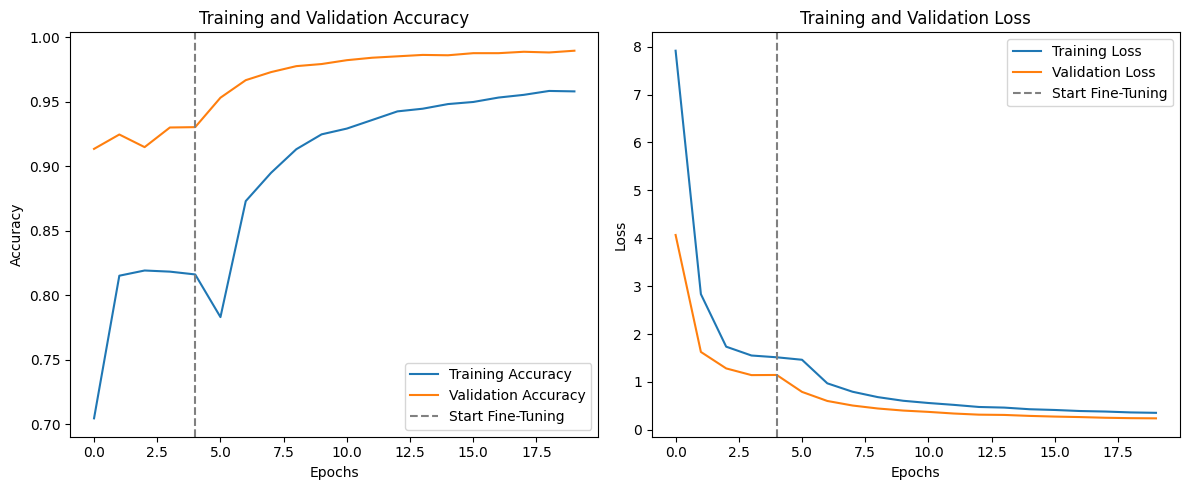

In [10]:
import matplotlib.pyplot as plt

# 1. Daten aus BEIDEN History-Objekten extrahieren und verbinden
# Listen-Addition (+) hängt die zweite Liste an die erste an
acc = history_warmup.history['accuracy'] + history.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history.history['val_accuracy']
loss = history_warmup.history['loss'] + history.history['loss']
val_loss = history_warmup.history['val_loss'] + history.history['val_loss']

# 2. Neue Range für die x-Achse definieren (Gesamtlänge)
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# --- Plot 1: Genauigkeit ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Eine vertikale Linie zeichnen, wo das Fine-Tuning begann
start_finetuning = len(history_warmup.history['accuracy']) - 1
plt.axvline(x=start_finetuning, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# --- Plot 2: Verlust ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Auch hier die Linie
plt.axvline(x=start_finetuning, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig(f"model_{MODEL_TYPE}_seed_{EXPERIMENT_SEED}_training_combined.png")
plt.show()